<a href="https://colab.research.google.com/github/LongNguyen1984/GANLearning/blob/main/SGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from random import random
import os
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import expand_dims
from numpy.random import randint
from numpy.random import randn
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Flatten, Dropout, Dense, Reshape
#import tensorflow_addons as tfa
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend
from keras.layers import Lambda
from keras import backend
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


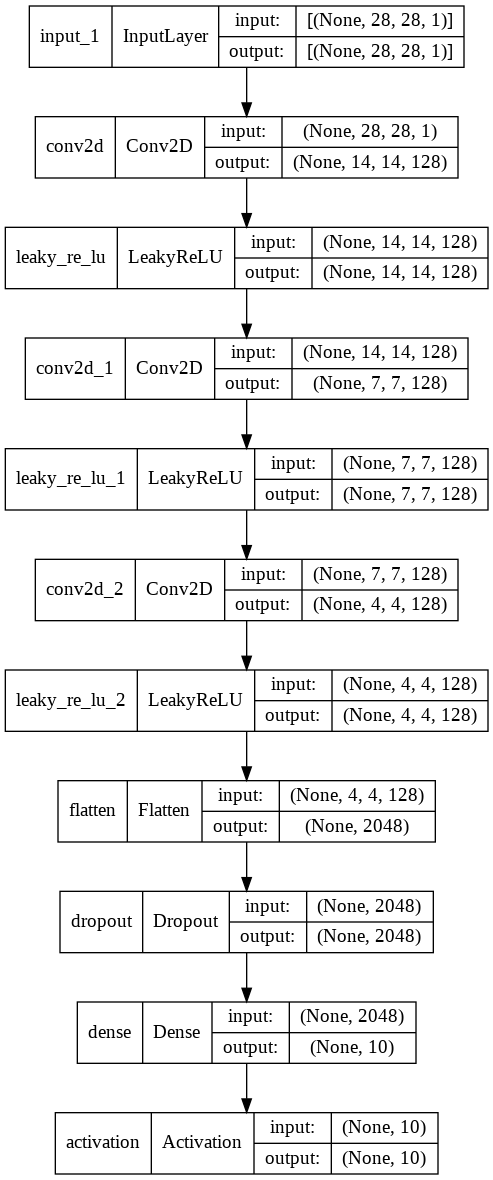

In [2]:
# custom activation function
def custom_activation(output):
  logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
  return logexpsum/(logexpsum+1.0)

# define the discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # image input
  in_image = Input(shape=in_shape)
  # downsample
  d = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  # downsample
  d = Conv2D(128, (3,3), strides=(2,2), padding='same')(d)
  d = LeakyReLU(alpha=0.2)(d)
  # downsample
  d = Conv2D(128, (3,3), strides=(2,2), padding='same')(d)
  d = LeakyReLU(alpha=0.2)(d)
  # flatten feature maps
  d = Flatten()(d)
  # dropout
  d = Dropout(0.4)(d)
  # output layer nodes
  d = Dense(n_classes)(d)
  # supervised output
  c_out_layer = Activation('softmax')(d)
  # define and compile supervised discriminator model
  c_model = Model(in_image, c_out_layer)
  c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
  # unsupervised output
  d_out_layer = Lambda(custom_activation)(d)
  # define and compile unsupervised discriminator model
  d_model = Model(in_image, d_out_layer)
  d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  return d_model, c_model

# create model
d_model, c_model = define_discriminator()
# plot the model
plot_model(d_model, to_file='stacked_discriminator1_plot.png', show_shapes=True,
show_layer_names=True)
plot_model(c_model, to_file='stacked_discriminator2_plot.png', show_shapes=True,
show_layer_names=True)

In [3]:
# define the generator model
def define_generator(latent_dim):
  # iamge generator input
  in_lat = Input(shape=(latent_dim,))
  # foudation for 7x7 image
  n_nodes = 128*7*7
  g = Dense(n_nodes)(in_lat)
  g = LeakyReLU(alpha=0.2)(g)
  g = Reshape((7,7,128))(g)
  # upsample to 14x14
  g = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(g)
  g = LeakyReLU(alpha=0.2)(g)
  # upsample to 28x28
  g = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(g)
  g = LeakyReLU(alpha=0.2)(g)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(g)
  # define model
  model = Model(in_lat, out_layer)
  return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make wieghts in the discriminator not trainable
  d_model.trainable = False
  # connect image output from gen as input to dis
  gan_output = d_model(g_model.output)
  # define gan model as takeing noise and outputting a classification
  model = Model(g_model.input, gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


In [7]:
# load fashion mnist images
def load_real_samples():
  # load dataset
  (trainX, trainy), (_,_) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0, 255] to [-1, 1]
  X = (X - 127.5)/127.5
  print(X.shape, trainy.shape)
  return [X, trainy]

# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
  X, y= dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples/n_classes)
  for i in range(n_classes):
    # get all images for this class
    X_with_class= X[y==i]
    # choose random instances
    ix = randint(0, len(X_with_class), n_per_class)
    # add to list
    [X_list.append(X_with_class[j]) for j in ix]
    [y_list.append(i) for j in ix]
  return asarray(X_list), asarray(y_list)


# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  z_input = randn(latent_dim*n_samples)
  # reshape into a batch of inputs for the network
  z_input = z_input.reshape(n_samples, latent_dim)
  return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict(z_input)
  # create class labels
  y = zeros((n_samples, 1))
  return images, y
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
  # prepare fake examples
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot images
  for i in range(100):
    # define subplot
    pyplot.subplot(10, 10, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
  filename1 = 'generated_plot_%04d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = 'model_%04d.h5' % (step+1)
  g_model.save(filename2)
  # save the classifier model
  filename3 = 'c_model_%04d.h5' % (step+1)
  c_model.save(filename3)
  print('>Saved: %s, %s and %s' % (filename1, filename2, filename3))
# train the generator and discriminator
def train(g_model, d_model, c_mdoel, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
  # select supervised dataset
  X_sup, y_sup = select_supervised_samples(dataset)
  print(X_sup.shape, y_sup.shape)
  # calculate the number of batches per training epoch
  bat_per_epo = int(dataset[0].shape[0]/n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  half_batch =int(n_batch/2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
  # manually enumerate epochs
  for i in range(n_steps):
    # get randomly selected 'real' samples
    [Xsup_real, ysup_real], y_real = generate_real_samples([X_sup, y_sup], half_batch)
    c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
    # update unsupervised discriminator (d) 
    [X_real, _], y_real = generate_real_samples(dataset, half_batch)
    d_loss1 = d_model.train_on_batch(X_real, y_real)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    d_loss2 = d_model.train_on_batch(X_fake, y_fake)
    ## update generator (g)
    X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    # summarize loss on this batch
    print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
    # evaluate the model performance every so often
    if (i+1) % (bat_per_epo * 1) == 0:
      summarize_performance(i, g_model, c_model, latent_dim, dataset)

In [ ]:
#size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model


In [ ]:
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

In [14]:
# example of loading the classifier model and generating images
from numpy import expand_dims
from keras.models import load_model
#from keras.datasets.mnist import load_data
from keras.datasets.fashion_mnist import load_data
# load the model
model = load_model('c_model_9360.h5')
# load the dataset
(trainX, trainy), (testX, testy) = load_data()
# expand to 3d, e.g. add channels
trainX = expand_dims(trainX, axis=-1)
testX = expand_dims(testX, axis=-1)
# convert from ints to floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# scale from [0,255] to [-1,1]
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Train Accuracy: 68.445%
Test Accuracy: 68.040%


In [ ]:
X, _ = generate_fake_samples(g_model, latent_dim, n_samples=100)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot images
pyplot.figure(figsize=(10,10))
for i in range(100):
  # define subplot
  
  pyplot.subplot(10, 10, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(X[i, :, :, 0], cmap='Accent')